In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import yfinance as yf

from datetime import datetime as dt

In [56]:
# We should take bigger timeframe for our model to be accurate
ticker = 'AAPL'
start_date = dt(2010, 1, 1)
end_date = dt.now()
# User can take any stock picker
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [57]:
df.shape

(3506, 6)

In [58]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478998,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490199,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386964,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375155,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417542,447610800
...,...,...,...,...,...,...
2023-11-30,189.839996,190.320007,188.190002,189.949997,189.949997,48794400
2023-12-01,190.330002,191.559998,189.229996,191.240005,191.240005,45679300
2023-12-04,189.979996,190.050003,187.449997,189.429993,189.429993,43389500


In [59]:
df.to_csv('output.csv', index=False)

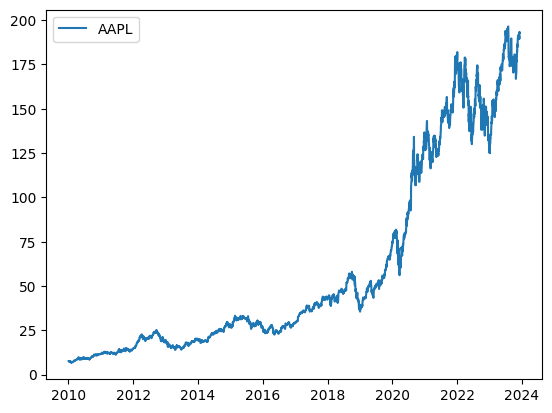

In [60]:
plt.plot(df['Close'],label = 'AAPL')
plt.legend()

In [61]:
# Dropping Date and Adj Close Column
df = df.drop(['Adj Close'], axis = 1)

In [62]:
df = df.reset_index(drop = True)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


In [63]:
# 100 days moving average
# Moving average for first 100 days is not defined as we need at least 100
# days data to get 100 day moving average
ma100 = df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3501    181.564201
3502    181.578901
3503    181.567801
3504    181.595101
3505    181.584151
Name: Close, Length: 3506, dtype: float64

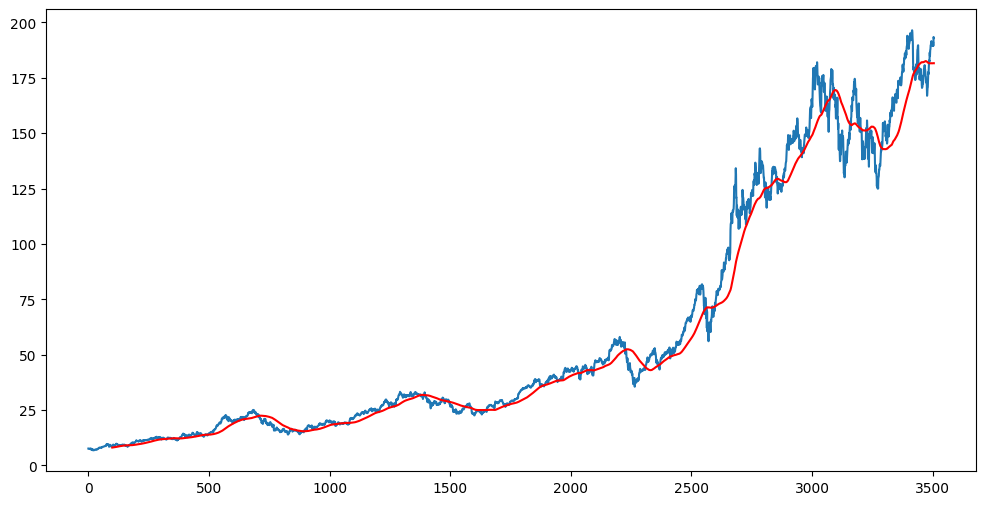

In [64]:
# Plotting 100 days moving average graph
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'red')

In [65]:
ma200 = df.Close.rolling(200).mean()
ma200

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3501    175.087600
3502    175.267150
3503    175.445750
3504    175.650100
3505    175.872175
Name: Close, Length: 3506, dtype: float64

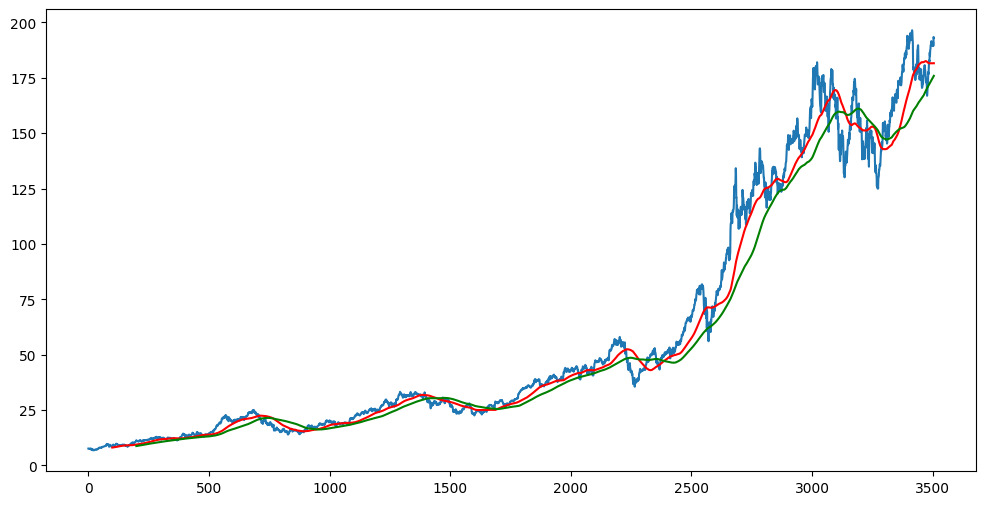

In [66]:
# Plotting 200 days moving average graph
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [67]:
# Splitting data into training and testing
# We take 70% data for training and 30% for testing
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.7):int (len(df))])
print(data_training.shape)
print(data_testing.shape)

(2454, 1)
(1052, 1)


In [68]:
# Now we should move on to scaling down data for LSTM model
# We have to scale down it between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [69]:
# scaler.fit_transform return an array
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.01533047],
       [0.01558878],
       [0.01320823],
       ...,
       [0.96041716],
       [0.96344693],
       [0.93593449]])

In [70]:
# Shape of data training array
data_training_array.shape

(2454, 1)

In [71]:
# First 100 days will be x_train
# And predicted value will be y_train
# In short x_train predicts y_train
x_train = []
y_train = []
for i in range(100,data_training_array.shape[0]):
  x_train.append(data_training_array[i-100:i])
  y_train.append(data_training_array[i,0])

In [72]:
# Converting x_train and y_train to numpy array
x_train, y_train = np.array(x_train),np.array(y_train)

In [73]:
x_train.shape

(2354, 100, 1)

In [74]:
y_train.shape

(2354,)

# Creating ML Model using LSTM (Long Short Time Memory)

In [75]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [76]:
model = Sequential()
# Adding Layers
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

# Connecting all layers
model.add(Dense(units = 1))

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_8 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_9 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_10 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

In [119]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs = 100)

Epoch 1/100
74/74 [==============================] - 13s 131ms/step - loss: 0.0018
Epoch 2/100
74/74 [==============================] - 10s 131ms/step - loss: 0.0020
Epoch 3/100
74/74 [==============================] - 10s 131ms/step - loss: 0.0018
Epoch 4/100
74/74 [==============================] - 10s 130ms/step - loss: 0.0017
Epoch 5/100
74/74 [==============================] - 10s 131ms/step - loss: 0.0017
Epoch 6/100
74/74 [==============================] - 10s 130ms/step - loss: 0.0019
Epoch 7/100
74/74 [==============================] - 10s 132ms/step - loss: 0.0019
Epoch 8/100
74/74 [==============================] - 10s 130ms/step - loss: 0.0018
Epoch 9/100
74/74 [==============================] - 10s 130ms/step - loss: 0.0018
Epoch 10/100
74/74 [==============================] - 10s 131ms/step - loss: 0.0017
Epoch 11/100
74/74 [==============================] - 10s 130ms/step - loss: 0.0017
Epoch 12/100
74/74 [==============================] - 10s 133ms/step - loss: 0.0018
E

In [120]:
model.save('keras_model100.keras')

In [121]:
data_testing.head()

,Close
2454,55.205002
2455,56.752499
2456,56.764999
2457,56.099998
2458,56.757500


In [122]:
past_100_days = data_training.tail(100)
past_100_days

,Close
2354,46.430000
2355,47.165001
2356,47.730000
2357,47.520000
2358,47.250000
...,...
2449,54.972500
2450,54.705002
2451,55.992500
2452,56.147499


In [123]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [124]:
final_df.head()

,Close
0,46.430000
1,47.165001
2,47.730000
3,47.520000
4,47.250000


In [125]:
# To scale down input data
input_data = scaler.fit_transform(final_df)
input_data

array([[0.02027755],
       [0.02507755],
       [0.02876734],
       ...,
       [0.95415507],
       [0.98021225],
       [0.97678372]])

In [126]:
input_data.shape

(1152, 1)

In [127]:
x_test = []
y_test = []
for i in range (100, input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])

In [128]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(1052, 100, 1)


In [129]:
y_test.shape

(1052,)

In [130]:
# Making predictions
y_predicted = model.predict(x_test)

33/33 [==============================] - 2s 42ms/step


In [131]:
y_predicted.shape

(1052, 1)

In [132]:
y_predicted

array([[0.13083825],
       [0.13190249],
       [0.13307539],
       ...,
       [0.8803626 ],
       [0.8785598 ],
       [0.8814534 ]], dtype=float32)

In [133]:
scaler.scale_

array([0.00653061])

In [134]:
scale_factor = 1/0.00682769
y_predicted = y_predicted*scale_factor
y_test = y_test * scale_factor

In [135]:
x_test

array([[[0.02027755],
        [0.02507755],
        [0.02876734],
        ...,
        [0.08272653],
        [0.08373877],
        [0.07454695]],

       [[0.02507755],
        [0.02876734],
        [0.02739592],
        ...,
        [0.08373877],
        [0.07454695],
        [0.07758368]],

       [[0.02876734],
        [0.02739592],
        [0.02563265],
        ...,
        [0.07454695],
        [0.07758368],
        [0.08768978]],

       ...,

       [[0.96140406],
        [0.96238371],
        [0.98393475],
        ...,
        [0.95376325],
        [0.95755102],
        [0.96597557]],

       [[0.96238371],
        [0.98393475],
        [0.98223673],
        ...,
        [0.95755102],
        [0.96597557],
        [0.95415507]],

       [[0.98393475],
        [0.98223673],
        [0.99118373],
        ...,
        [0.96597557],
        [0.95415507],
        [0.98021225]]])

In [136]:
# Invert scaling to get the actual prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predicted_actual = scaler.inverse_transform(y_predicted.reshape(-1, 1))

# Create a DataFrame to display the table
result_table = pd.DataFrame({
    'Actual Price': y_test_actual[:, 0],  # No need for flatten()
    'Predicted Price': y_predicted_actual[:, 0]  # No need for flatten()
})

# Print the result table
print(result_table)


      Actual Price  Predicted Price
0      1783.298706      2977.641602
1      2009.948832      3001.509277
2      2011.779724      3027.814209
3      1914.382080      3055.437500
4      2010.681300      3080.979004
...            ...              ...
1047  21518.376766     19821.658203
1048  21707.314539     19788.662109
1049  21442.215682     19787.267578
1050  22026.601542     19746.837891
1051  21949.709665     19811.730469

[1052 rows x 2 columns]


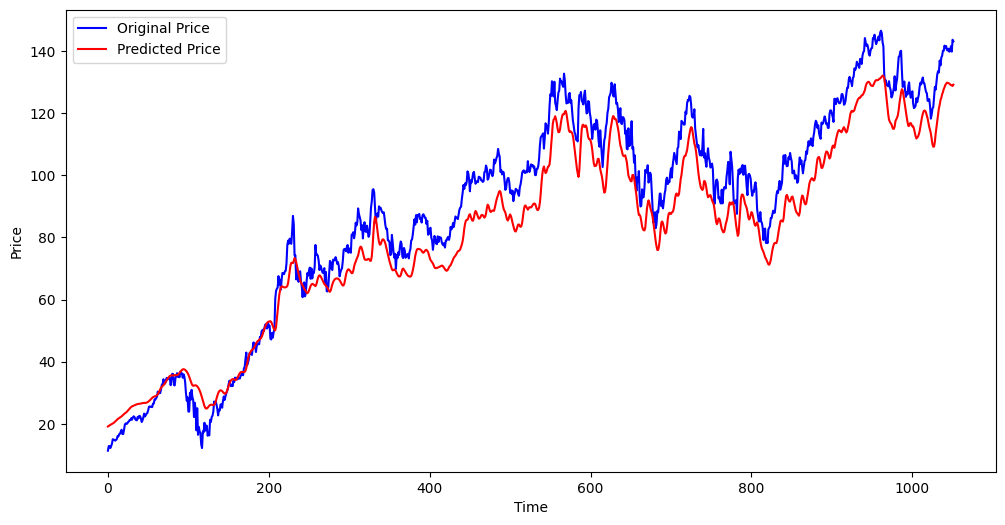

In [137]:
plt.figure(figsize = (12,6))
plt.plot(y_test ,'b',label='Original Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [138]:
input_data = scaler.fit_transform(final_df)
import keras as keras
model = keras.models.load_model('keras_model.keras')

In [139]:
input_data = scaler.fit_transform(final_df)

# Get the last 100 days of data from the testing set
x_next_day = input_data[-100:]

# Reshape the data to match the input shape of the model
x_next_day = x_next_day.reshape(1, x_next_day.shape[0], 1)

import keras as keras
# Load the above trained model
model = keras.models.load_model('keras_model.keras')

# Use the trained model to predict the stock price for the next day
predicted_next_day_price = model.predict(x_next_day)

# Invert the scaling to get the actual stock price
predicted_next_day_price = scaler.inverse_transform(predicted_next_day_price.reshape(-1, 1))

# Print the predicted stock price for the next day
print("Predicted Stock Price for the Next Day:", predicted_next_day_price[0, 0])

1/1 [==============================] - 0s 402ms/step
Predicted Stock Price for the Next Day: 178.67583
